In [85]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from sklearn.metrics import mean_squared_error

## EDA

Most of the EDA was done in the previous implementation.

In [2]:
df = yf.download(tickers='NVDA', start='2015-01-01')

[*********************100%***********************]  1 of 1 completed


In [10]:
df['log_return'] = np.log(1 + df['Adj Close'].pct_change())
df = df.dropna()

In [6]:
def adf_test(dataset):

    dftest = adfuller(dataset, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    return print(dfoutput)

### Evaluation of Variables
For the data to be stationary, the p-value of the ADF test should be <= significance level (0.05 for this example). If the p-value is greater than the significance level then we can say that it is likely that the data is not stationary.

From the results below, we can see that `'Adj Close'` is almost certainly not stationary but `'log_returns'` is.

In [14]:
adf_test(df['Adj Close'])

Test Statistic                    0.493467
p-value                           0.984673
#Lags Used                       27.000000
Number of Observations Used    2187.000000
dtype: float64


In [15]:
adf_test(df['log_return'])

Test Statistic                -1.682759e+01
p-value                        1.164886e-29
#Lags Used                     7.000000e+00
Number of Observations Used    2.207000e+03
dtype: float64


## Data Preparation

In [37]:
# Define function to split data into train, val, test
def split(dataset, days_to_test):
    
    # DAYS_TO_PRED rows will be removed for test data, remaining split .8 .2
    test_val_len = len(dataset) - days_to_test
    l_80 = int(test_val_len * 0.8)
    train_data, val_data, test_data = dataset[: l_80], dataset[l_80 : test_val_len], dataset[test_val_len :]
    
    if test_data.empty:
        return train_data, val_data
    else:
        return train_data, val_data, test_data

In [38]:
# No need for val data
train_data, test_data = split(df, 0)

In [39]:
df.shape, train_data.shape, test_data.shape

((2215, 7), (1772, 7), (443, 7))

## Model Diagnostics

The Standardized residual, Histogram plus KDE estimate, Normal q-q, and the correlogram. We can interpret the model as a good fit based on the following conditions.

- ### Standardized residual
    There are no obvious patterns in the residuals, with values having a mean of zero and having a uniform variance.

- ### Histogram plus KDE estimate
    The KDE curve should be very similar to the normal distribution (labeled as N(0,1) in the plot)

- ### Normal Q-Q
    Most of the data points should lie on the straight line

- ### Correlogram (ACF plot)
    95% of correlations for lag greater than zero should not be significant. The grey area is the confidence band, and if values fall outside of this then they are statistically significant. In our case, there are a few values outside of this area, and therefore we may need to add more predictors to make the model more accurate

In [30]:
ARIMA_model = pm.auto_arima(df['log_return'], 
                      #start_p=1, 
                      #start_q=1,
                      #test='adf',
                      #max_p=3, max_q=3,
                      #m=1, 
                      #d=None,# let model determine 'd'
                      #seasonal=False,
                      trace=True, #logs 
                      #error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

ARIMA_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-9206.464, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-9203.785, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-9211.606, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-9211.190, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-9196.052, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-9210.416, Time=0.40 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-9210.226, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-9208.467, Time=0.36 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-9202.528, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.502 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2215
Model:               SARIMAX(1, 0, 0)   Log Likelihood                4608.803
Date:                Tue, 24 Oct 2023   AIC                          -9211.606
Time:                        09:50:05   BIC                          -9194.497
Sample:                             0   HQIC                         -9205.357
                               - 2215                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0021      0.001      3.324      0.001       0.001       0.003
ar.L1         -0.0665      0.014     -4.605      0.000      -0.095      -0.038
sigma2         0.0009   1.28e-05     71.051      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4968.69
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.73   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

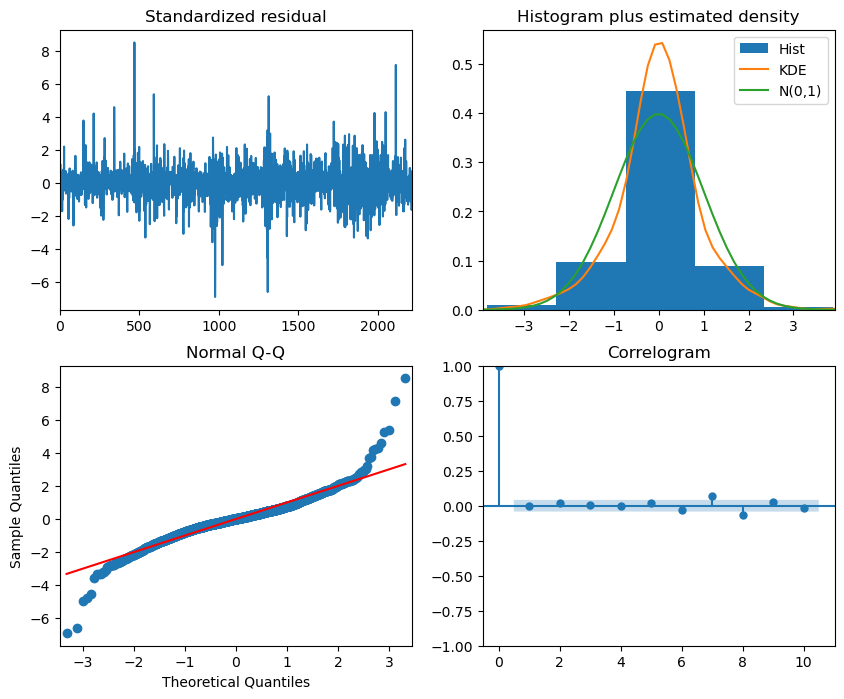

In [24]:
ARIMA_model.plot_diagnostics(figsize=(10, 8))
plt.show()

## ARIMA Implementation

In [44]:
model = ARIMA(train_data['log_return'], order=(1, 0, 0))
model = model.fit()
model.summary()

/Users/gareth/anaconda3/envs/lstm/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/gareth/anaconda3/envs/lstm/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/gareth/anaconda3/envs/lstm/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             log_return   No. Observations:                 1772
Model:                 ARIMA(1, 0, 0)   Log Likelihood                3799.131
Date:                Tue, 24 Oct 2023   AIC                          -7592.262
Time:                        10:10:18   BIC                          -7575.822
Sample:                             0   HQIC                         -7586.189
                               - 1772                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      3.671      0.000       0.001       0.003
ar.L1         -0.0994      0.014     -7.108      0.000      -0.127      -0.072
sigma2         0.0008   1.13e-05     70.972      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              6714.71
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.55   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [89]:
test_start_date = len(train_data) # 1772
test_end_date = test_start_date + len(test_data) - 1 # 1772 + 443 - 1

In [90]:
# Prediction on test data
test_predict = model.predict(start=test_start_date, end=test_end_date) # end is pos nt index
test_predict.index = df.index[test_start_date : test_end_date + 1]
test_predict

/Users/gareth/anaconda3/envs/lstm/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/gareth/anaconda3/envs/lstm/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Date
2022-01-18    0.001129
2022-01-19    0.002380
2022-01-20    0.002256
2022-01-21    0.002268
2022-01-24    0.002267
                ...   
2023-10-16    0.002267
2023-10-17    0.002267
2023-10-18    0.002267
2023-10-19    0.002267
2023-10-20    0.002267
Name: predicted_mean, Length: 443, dtype: float64

### Model Evaluation

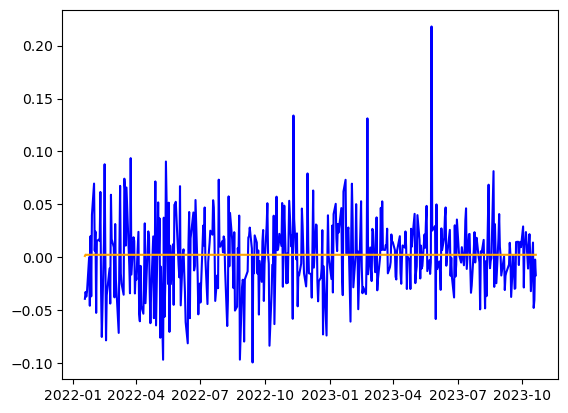

In [91]:
plt.plot(test_data['log_return'], color='blue')
plt.plot(test_predict, color='orange')
plt.show()

In [86]:
def calc_rmse(actual, prediction):
    return mean_squared_error(actual, prediction, squared=False)

In [92]:
print(
    #'Train RMSE:', calc_rmse(y_train, train_predict),'\n'
    'Test RMSE:', calc_rmse(test_data['log_return'], test_predict)
    )

Test RMSE: 0.036531809470858066
